In [30]:
# Importing the libraries
from numpy.lib.function_base import average
import pandas as pd
import numpy as np
from math import sqrt, pi, exp, ceil
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sn

In [31]:
# Reading the data
data = pd.read_csv("SPECTF_test.csv")
data.columns = [a for a in range(45)]
global_predicted = []
global_actual = []

In [32]:
# Function to find the Gaussian Probability statistic
def gaussian_value(val, mean, std_dev):
    exponent = exp(-((val-mean)**2 / (2 * std_dev**2)))
    return ((1 / (sqrt(2 * pi) * std_dev)) * exponent)

In [33]:
# Function to get final probility in a fold
def final_probability(summaries, num_data, num_attr, to_classify_row):
    probabilties = {}
    for cls, cls_summaries in summaries.items():
        probabilties[cls] = summaries[cls][0][2] / num_data
        for a in range(num_attr):
            mean, std_dev, count = cls_summaries[a]
            probabilties[cls] *= gaussian_value(to_classify_row[a], mean, std_dev)
    return probabilties

In [34]:
# Function to perform single fold naive bayes
def naive_bayes(data, num_attr, to_classify):
    num_data = len(data)

    data_classes = {}
    for a in range(num_data):
        cls = data.iloc[a][num_attr]
        if cls not in data_classes:
            data_classes[cls] = []
        data_classes[cls].append(data.iloc[a])

    summaries = {}
    for cls, rows in data_classes.items():
        tmp = pd.DataFrame(rows)
        summaries[cls] = [(tmp[attr].mean(), tmp[attr].std(), len(tmp)) for attr in range(num_attr)]


    probabilties = []
    for a in range(len(to_classify)):
        probabilties.append(final_probability(summaries, num_data, num_attr, to_classify.iloc[a]))

    return probabilties

In [35]:
# Function to get accuracy of each fold validation
def get_accuracy(probabilties, actual, global_predicted, global_actual):
    proba_classes = [max(proba.items(), key=itemgetter(1))[0] for proba in probabilties]
    
    correct = 0
    for a in range(len(actual)):
        if actual[a] == proba_classes[a]:
            correct += 1
    accuracy = correct / float(len(actual)) * 100.0
    
    global_predicted += proba_classes
    global_actual += actual
    
    y_actu = pd.Series(actual, name='Actual')
    y_pred = pd.Series(proba_classes, name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    plt.figure(figsize = (10,7))
    plt.title('Confusion Matrix', fontsize = 20)
    sn.heatmap(df_confusion, annot=True)
    plt.show()

    return accuracy

In [36]:
# Function to perform n fold naive bayes
def naive_bayes_n_fold(data, num_attr, n_folds, global_predicted, global_actual):
    num_data = len(data)
    data = data.sample(frac=1).reset_index(drop=True)
    
    fold_len = ceil(num_data / n_folds)
    folds = []
    data_left = num_data
    ind = 0
    for a in range(n_folds):
        if data_left > fold_len:
            folds.append(data.iloc[ind:(ind+fold_len)])
            ind += fold_len
            data_left -= fold_len
        else:
            folds.append(data.iloc[ind:(ind+data_left)])
    
    scores = []
    for a in range(n_folds):
        test_set = folds[a]
        train_set = folds[:a]
        if a != (n_folds - 1):
            train_set += folds[a+1:]
        train_set = pd.concat(train_set, axis=0)

        probabilties = naive_bayes(train_set, num_attr, test_set)
        scores.append(get_accuracy(probabilties, list(test_set[num_attr]), global_predicted, global_actual))
    return scores

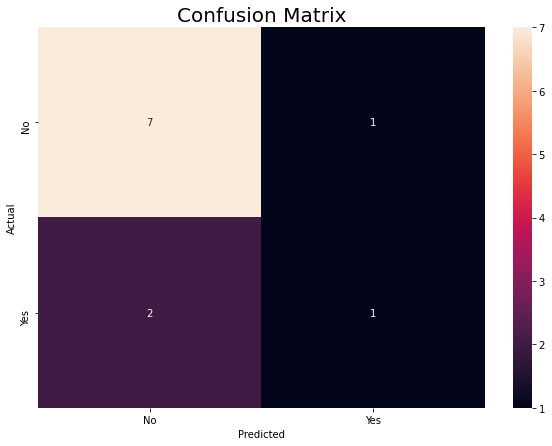

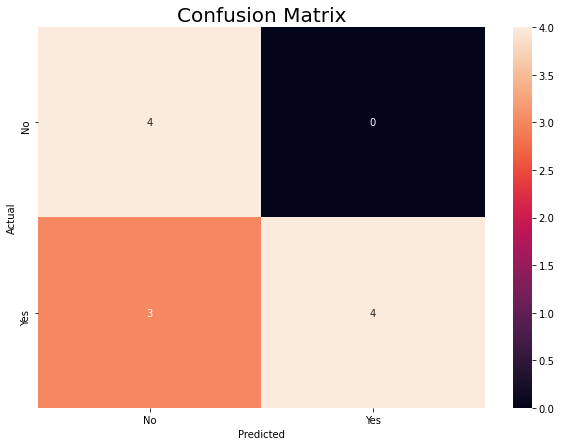

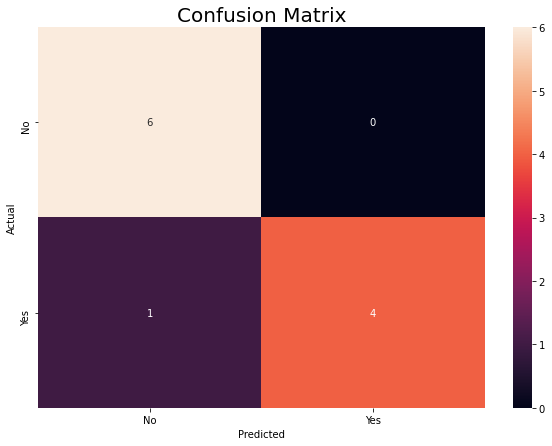

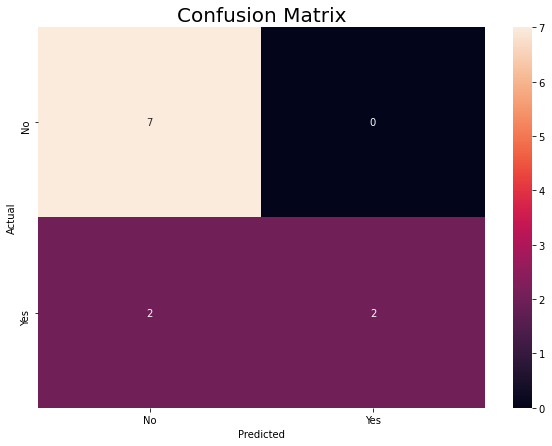

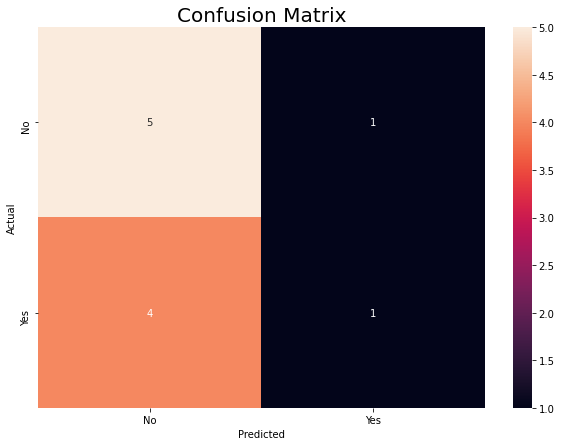

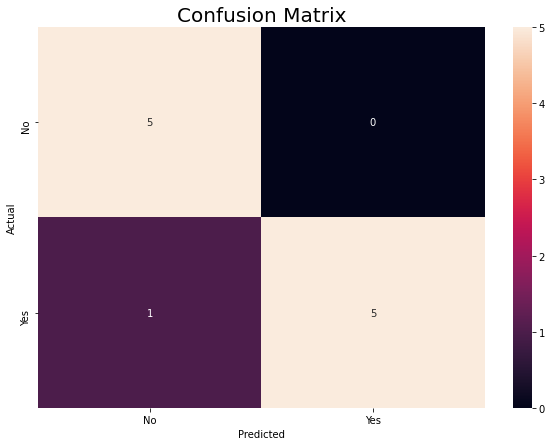

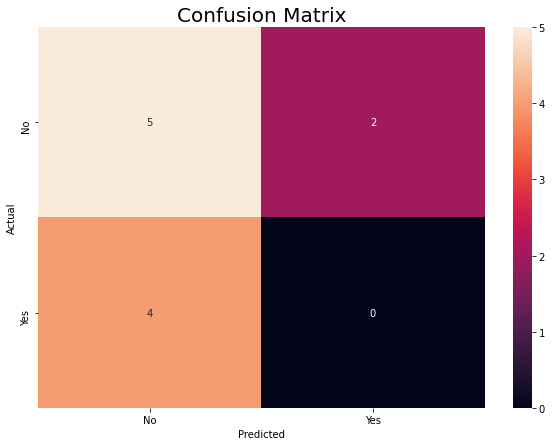

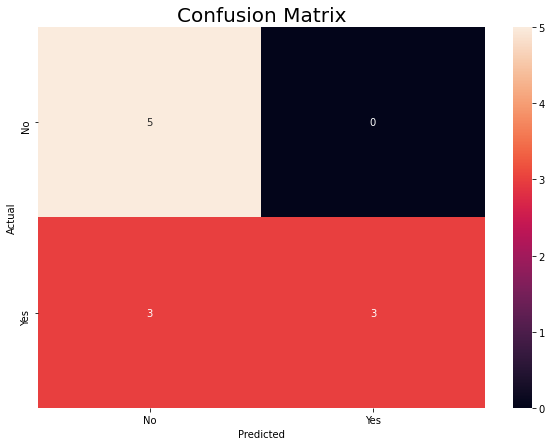

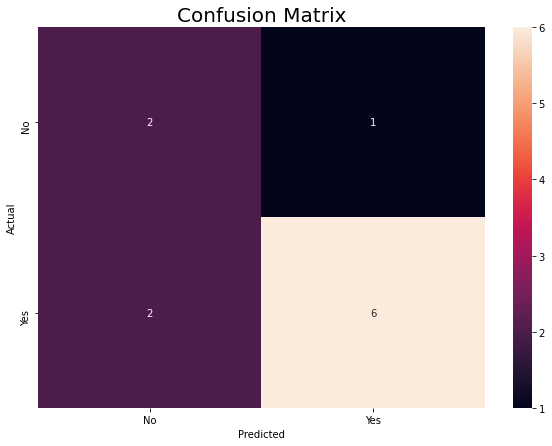

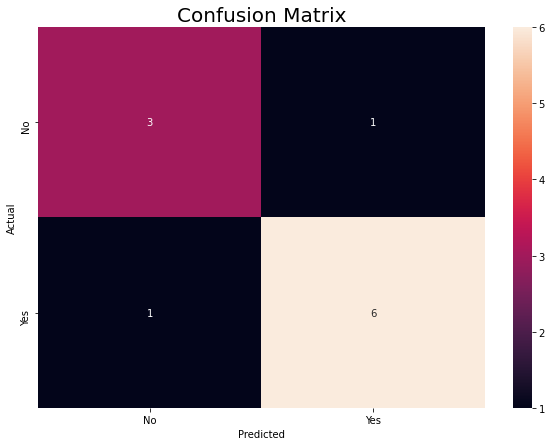

In [37]:
# Function to perform n fold naive bayes
scores = naive_bayes_n_fold(data, 44, 10, global_predicted, global_actual)

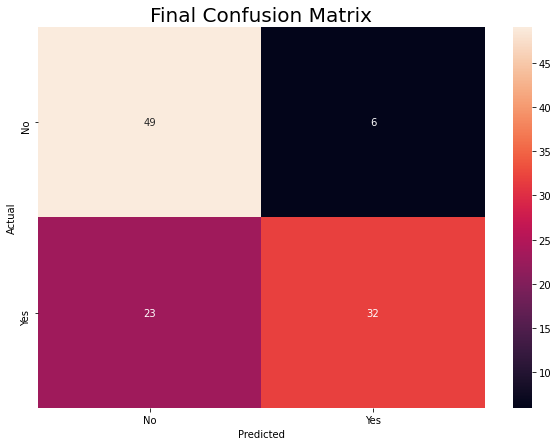

In [38]:
# Calculating the final confusion matrix

y_actu = pd.Series(global_actual, name='Actual')
y_pred = pd.Series(global_predicted, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
plt.figure(figsize = (10,7))
plt.title('Final Confusion Matrix', fontsize = 20)
sn.heatmap(df_confusion, annot=True)
plt.show()

In [39]:
# Printing accuracies of each fold
i = 0
for i,score in enumerate(scores):
    print("Accuracy of fold ", i+1, " = ", score)

Accuracy of fold  1  =  72.72727272727273
Accuracy of fold  2  =  72.72727272727273
Accuracy of fold  3  =  90.9090909090909
Accuracy of fold  4  =  81.81818181818183
Accuracy of fold  5  =  54.54545454545454
Accuracy of fold  6  =  90.9090909090909
Accuracy of fold  7  =  45.45454545454545
Accuracy of fold  8  =  72.72727272727273
Accuracy of fold  9  =  72.72727272727273
Accuracy of fold  10  =  81.81818181818183


In [40]:
print("Final Average Accuracy = ", average(scores))

Final Average Accuracy =  73.63636363636365
